<a href="https://colab.research.google.com/github/thedenaas/jub_ml/blob/main/fall_2022/seminar_4/seminar4_torch_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import math
import numpy as np 
import time

import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats

from tqdm.notebook import tqdm

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt

# Exercise: Autoencoder 

Autoencoder is a special neural architecture that allows you to get compressed representations and many other cool things of data without labels. A typical autoencoder consists of an encoder and a decoder: the encoder transforms data into a hidden (latent) space (representation), and the decoder recovers the original data from the hidden space. The autoencoder is trained to reconstruct trainig images, i.e. the output of decoder should be similar to the input of encoder. This can be realized by training the model end-to-end on pixel-wise MSE loss:

$L_{ae} = \frac{1}{N_{pixels}} \sum_{pixels} (x_i - dec(enc(x))_i)^2$

where $x_i$ is a color of i-th pixel of an image (in practice, actual loss is also a sum over a batch of images, but I omitted it in the equation for brevity). Importantly, autoencoder cannot simply copy the input image, because the latent space is significantly smaller than the input space, so the image has to be compressed. This smaller latent space is called a bottleneck.

 The simplest usecase is to train the autoencoder to compress images into a smaller latent space (labels are not needed), and then use this latent representation (encoder output) as features for training a classifier/regressor/something else on our labeled data. A more interesting usecase is image generation by sampling new points in latent space, although good generation requires more complex architectures.

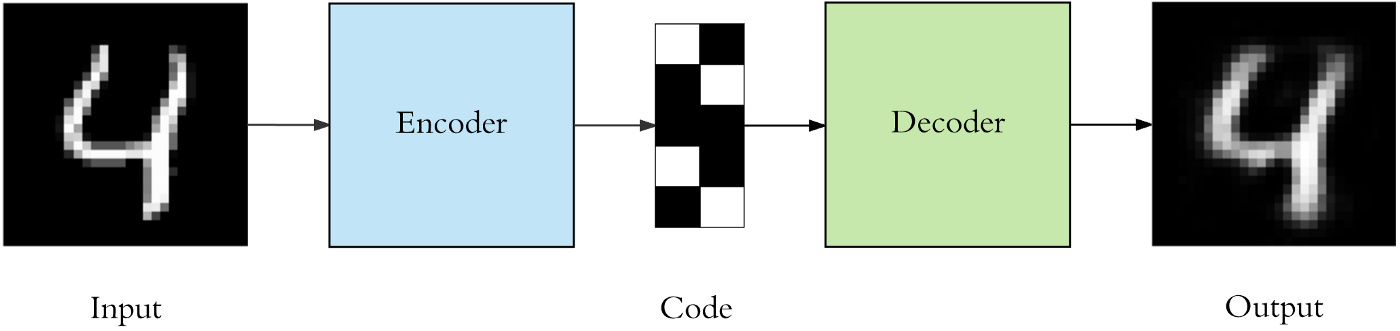

## utils

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5), 
    transforms.Lambda(lambda x: torch.flatten(x))
])

In [4]:
traindata = MNIST(
    root='./data',
    train=True, 
    transform=transform,
    download=True
)
testdata = MNIST(
    root='./data',
    train=False, 
    transform=transform,
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
batch_size = 64

trainloader = DataLoader(
    dataset=traindata,
    batch_size=batch_size,
    shuffle=True
)
testloader = DataLoader(
    dataset=testdata,
    batch_size=batch_size,
    shuffle=False)

In [9]:
@torch.no_grad()
def show_reconstruction(encoder, decoder, dataloader):
    x, _ = iter(dataloader).next()
    x = x[:10]

    x_rec = decoder(encoder(x))

    x = x.reshape(-1, 28, 28)
    x_rec = x_rec.reshape(-1, 28, 28)

    img = torch.cat((x, x_rec))
    img = img.unsqueeze(1)
    img = make_grid(img, nrow=10)
    img = tensor_to_image(img)
    img = img.clip(0, 1)

    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [10]:
def tensor_to_image(x):
    x = x.detach().cpu().numpy()
    x = x.transpose(1, 2, 0)
    x = (x + 1) / 2
    return x

In [11]:
def accuracy_test(model, dataloader):
    preds = []
    ys = []
    for (x, y) in dataloader:
        pred = model(x).detach().numpy().squeeze()
        preds.append(pred)
        ys.append(y)
    
    preds = np.vstack(preds)
    ys = np.hstack(ys)
    
    return accuracy_score(ys, np.argmax(preds, axis=1))

## tasks

**1.** Implement an autoencoder model. We will work with 28x28 flatten images of digits (784 dimensional vector). Your encoder should be a neural net with input dim=784 and output dim=128. For decoder, dimensions are swapped.

In [13]:
encoder = nn.Sequential(nn.Linear(784, 256), 
                        nn.ReLU(), 
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Linear(128, 128))

decoder = nn.Sequential(nn.Linear(128, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 256),
                        nn.ReLU(),
                        nn.Linear(256, 784))

In [14]:
opt_enc = opt.Adam(encoder.parameters(), lr=1e-3)
opt_dec = opt.Adam(decoder.parameters(), lr=1e-3)

In [15]:
def train1(encoder, decoder, trainloader, opt_enc, opt_dec, num_epochs=5):
    for epoch in range(num_epochs):
        for (x, y) in trainloader:
            encoded_x = encoder(x)
            decoded_x = decoder(encoded_x)
            loss = F.mse_loss(decoded_x, x)

            opt_enc.zero_grad()
            opt_dec.zero_grad()

            loss.backward()

            opt_enc.step()
            opt_dec.step()    

In [16]:
train1(encoder, decoder, trainloader, opt_enc, opt_dec, 5)

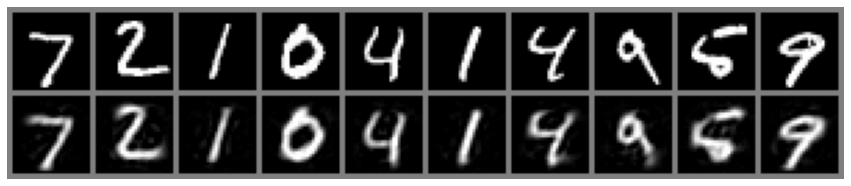

In [17]:
# run this cell to show quality of trained autoencoder
show_reconstruction(encoder, decoder, testloader)

**2.** Here we will train two classifiers on MNIST dataset.

First, lets make a classifier on initial data (data dimension is 784). Your model should output a 10 dimensional vector of probabilities (for each digit). Use nn.Softmax(dim=-1) as last layer in your model.

In [18]:
classifier = nn.Sequential(nn.Linear(784, 256), 
                           nn.ReLU(), 
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 10), 
                           nn.Softmax(dim=-1))

In [19]:
opt_clf = opt.Adam(classifier.parameters(), lr=1e-3)

In [20]:
def train2(classifier, trainloader, opt_clf, num_epochs=10):

    for epoch in range(num_epochs):
        for (x, y) in trainloader:
            preds = classifier(x)
            loss = F.cross_entropy(preds, y)

            opt_clf.zero_grad()
            loss.backward()
            opt_clf.step()    

In [21]:
train2(classifier, trainloader, opt_clf, 10)

In [22]:
# run this cell to calculate an accuracy
accuracy_test(classifier, testloader)

0.9622

Now, train a classifier on an encoded mnist data. For this implement a function that encodes data

In [23]:
def encode_data(encoder, dataloder, batch_size=batch_size, shuffle=True):
    xs = []
    ys = []

    for (x, y) in dataloder:
        xe = encoder(x)
        xs.append(xe)
        ys.append(y)
    
    new_x = torch.vstack(xs).detach()
    new_y = torch.hstack(ys)
    

    dataset = data.TensorDataset(new_x.detach(), new_y) # new_x - encoded images, new_y - old labels of enocoded images
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [25]:
encoded_train_loader = encode_data(encoder, trainloader, batch_size, True)
encoded_test_loader = encode_data(encoder, testloader, batch_size, False)

In [26]:
classifier_e = nn.Sequential(nn.Linear(128, 256), 
                           nn.ReLU(), 
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 10), 
                           nn.Softmax(dim=-1))

In [27]:
opt_clf = opt.Adam(classifier_e.parameters(), lr=1e-3)

In [28]:
train2(classifier_e, encoded_train_loader, opt_clf, 10)

In [29]:
# run this cell to calculate an accuracy
accuracy_test(classifier_e, encoded_test_loader)

0.9734

Compare results of both classifiers.

**3.** Train an encoder with additional L_2 penalty on encoded_x, i.e. add MSE from latent representation to 0 to the loss:

$L_{ae+l2} = L_{ae} + \lambda enc(x)^2$

This will penalize high values in the latent representation and make it more compact, which will be useful in task 4.

In [30]:
encoder_r = nn.Sequential(nn.Linear(784, 256), 
                        nn.ReLU(), 
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Linear(128, 128))

decoder_r = nn.Sequential(nn.Linear(128, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 256),
                        nn.ReLU(),
                        nn.Linear(256, 784))

In [31]:
opt_enc = opt.Adam(encoder_r.parameters(), lr=1e-3)
opt_dec = opt.Adam(decoder_r.parameters(), lr=1e-3)

In [32]:
def train3(encoder, decoder, trainloader, opt_enc, opt_dec, lam=5, num_epochs=5):

    for epoch in tqdm(range(num_epochs)):
        for (x, y) in trainloader:
            encoded_x = encoder(x) # 
            decoded_x = decoder(encoded_x) #
            loss = F.mse_loss(decoded_x, x) + lam * ((encoded_x) ** 2).mean() #

            opt_enc.zero_grad()
            opt_dec.zero_grad()

            loss.backward()

            opt_enc.step()
            opt_dec.step()    

In [33]:
train3(encoder_r, decoder_r, trainloader, opt_enc, opt_dec, 1, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

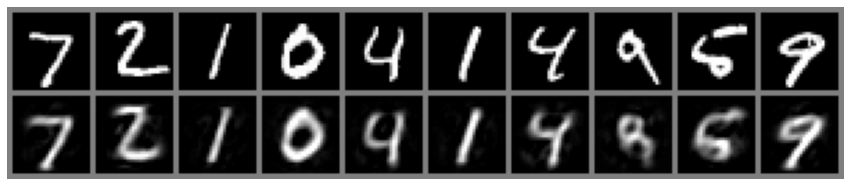

In [34]:
# run this cell to show quality of trained autoencoder
show_reconstruction(encoder_r, decoder_r, testloader)

**4.** Interpolate from one image to another by mixing latent representations of the two images.

In [42]:
def show_interpolation(dataloader, encode, decode):
    x, _ = iter(dataloader).next()
    x = x

    x1, x2 = x[:10], x[1:11]


    c1 = encode(x1) # encode x1 [10, 128]
    c2 = encode(x2) # encode x2 [10, 128]

    ks = np.linspace(0, 1, num=10)
    ks = torch.FloatTensor(ks)
    ks = ks.reshape((1, 10, *([1] * (len(c1.shape) - 1)))) # [1, 10, 1]

    c1 = c1.unsqueeze(1)
    c2 = c2.unsqueeze(1)

    ks = ks.repeat(c1.shape) # [10, 10, 128]

    c = ks * c1 + (1 - ks) * c2 # make a list of linear combinations of c1 and c2 with ks as weights [10, 10, 128]
    c = c.flatten(end_dim=1) # [100, 128]
    img = decode(c) # decode c

    img = img.view(-1, 1, 28, 28)
    img = make_grid(img, nrow=10)
    img = tensor_to_image(img)
    img = img.clip(0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

torch.Size([10, 128])
torch.Size([1, 10, 1])
torch.Size([10, 10, 128])
torch.Size([10, 10, 128])
torch.Size([100, 128])


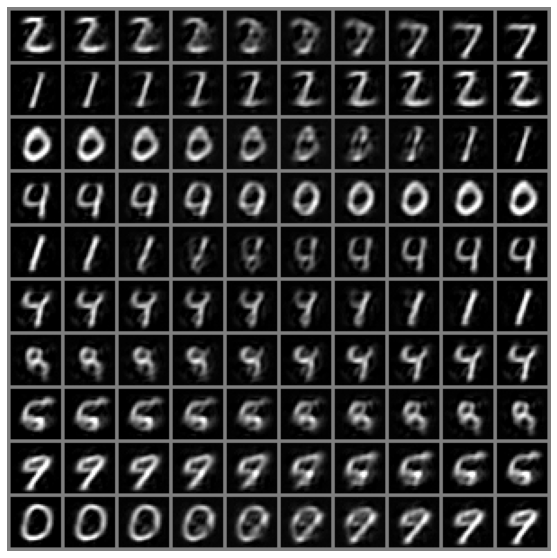

In [43]:
# show interpolation for encoder_r
show_interpolation(testloader, encoder_r, decoder_r)

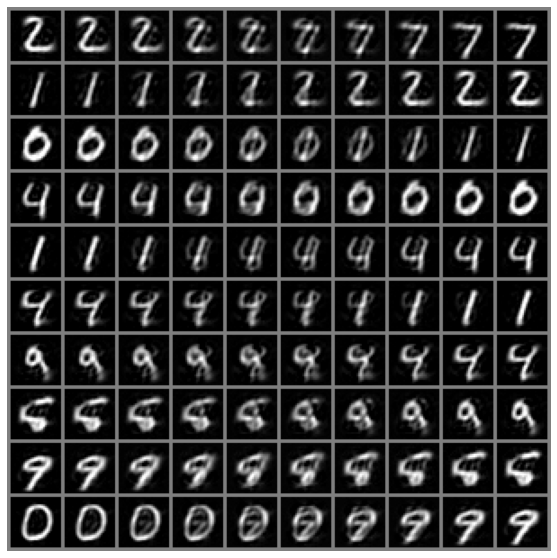

In [37]:
# show interpolation for encoder
show_interpolation(testloader, encoder, decoder)

What can you say about interpolations of encoder w/ and w/out regularization.

# Usefull links


* [Neural net playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2,2,2&seed=0.55500&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=true&ySquared=true&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

* [basic torch tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html)

* [sequence models tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

* [image models tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

